In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import tqdm

### Data

In [2]:
tetragonal = pd.read_csv('data/tetragonal.csv')
tetragonal = tetragonal[tetragonal.Zr > 0]

monoclinic = pd.read_csv('data/monoclinic.csv')
monoclinic = monoclinic[monoclinic.Zr > 0]

In [3]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs = ['a']

### ML

In [4]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
def get_stats(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rsq, _ = stats.pearsonr(y_true, y_pred)
    
    return rmse, rsq
    
def plot_train_test(reg, Xr, Xt, yr, yt, unit='Å', figtitle=''):
    fig, ax_fig = plt.subplots(1, 2, figsize=(8, 4))

    for idx, (title, color, x_plot, y_plot) in enumerate(zip(
        ['train', 'test'],
        ['#1f77b4', '#ff7f0e'],
        [Xr, Xt],
        [yr, yt]
    )):
        ax = ax_fig[idx]

        y_pred = reg.predict(x_plot)
        ax.scatter(y_plot, y_pred, alpha=0.6, c=color)

        rmse, rsq = get_stats(y_plot, y_pred)

        lim_min = min(np.min(y_plot), np.min(y_plot))
        lim_max = max(np.max(y_plot), np.max(y_plot))
        lims = (lim_min, lim_max)

        ax.plot(lims, lims, 'k', zorder=-1)

        ax.annotate(
            'RMSE = %.2e %s\nR$^2$ = %.2f' % (rmse, unit, rsq),
            (0.05, 0.96),
            xycoords='axes fraction',
            va='top',
            fontsize=12
        )

        ax.set_xlabel(f'True lattice parameter ({unit})', fontsize=12)

        if idx == 0:
            ax.set_ylabel(f'Predicted lattice parameter ({unit})', fontsize=12)

        ax.set_title(title)

        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
    fig.suptitle(figtitle)
    plt.show()

In [6]:
inputs = ['T']

def get_model(features, output, df):
    X = df[inputs + features].values
    y = df[output].values.reshape(-1)
    Xr, Xt, yr, yt = train_test_split(X, y, test_size=0.3)
    
    reg  = BayesianRidge(compute_score=True)
    reg.fit(Xr, yr)
    
    return reg, Xr, Xt, yr, yt

In [7]:
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs_tetragonal = ['a', 'c']
outputs_monoclinic = ['a', 'b', 'c', 'beta']

### Features selection

In [71]:
summary = pd.DataFrame(
    columns=['num_features', 'features', 'parameter', 'rmse', 'rsq']
)

In [72]:
NRUNS = 50
for _ in tqdm.trange(NRUNS):
    for df, lattice, outputs in zip(
        [tetragonal, monoclinic],
        ['tetragonal', 'monoclinic'],
        [outputs_tetragonal, outputs_monoclinic],
    ):
        for output in outputs:
            
            for num_features in range(len(features)):
                for feat in itertools.combinations(features, num_features):
            
                    reg, Xr, Xt, yr, yt = get_model(list(feat), output, df)

                    rmse, rsq = get_stats(yt, reg.predict(Xt))

                    summary = summary.append({
                        'num_features': num_features,
                        'features': ','.join(inputs + list(feat)),
                        'parameter': '%s_%s' % (lattice, output),
                        'rmse': rmse,
                        'rsq': rsq
                    }, ignore_index=True)


100%|██████████| 50/50 [05:23<00:00,  6.47s/it]


In [73]:
fsummary = summary.groupby(['features', 'parameter']).mean()['rmse'].unstack()
fsummary_rsq = summary.groupby(['features', 'parameter']).mean()['rsq'].unstack()

In [74]:
fsummary

parameter,monoclinic_a,monoclinic_b,monoclinic_beta,monoclinic_c,tetragonal_a,tetragonal_c
features,,,,,,
T,0.025416,0.015400,0.138102,0.025493,0.017271,0.030012
"T,ea",0.024495,0.014154,0.134437,0.024202,0.017177,0.030094
"T,ea,pettifor",0.027703,0.012434,0.135558,0.023789,0.015200,0.029675
"T,ea,pettifor,rad_clementi",0.014149,0.012427,0.066899,0.010004,0.012194,0.024383
"T,ea,pettifor,rad_ionic",0.005179,0.011756,0.119708,0.012465,0.008407,0.028442
"T,ea,pettifor,rad_ionic,rad_clementi",0.004533,0.006357,0.087135,0.006379,0.005915,0.024051
"T,ea,pettifor,rad_ionic,rad_slater",0.004201,0.008051,0.118521,0.007241,0.004793,0.019879
"T,ea,pettifor,rad_ionic,rad_slater,rad_clementi",0.004177,0.006997,0.068874,0.004532,0.004747,0.022926
"T,ea,pettifor,rad_slater",0.004462,0.010601,0.110172,0.009667,0.004858,0.023087


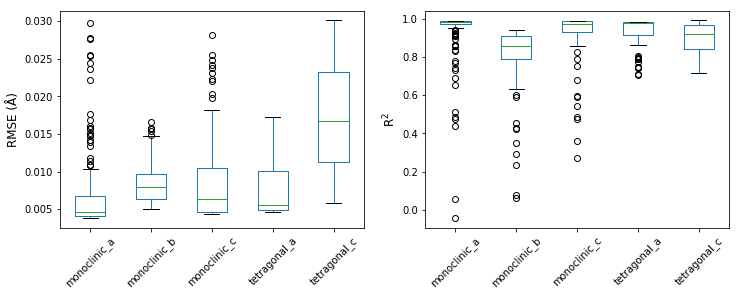

In [75]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 4))

for df, ax, label in zip(
    [fsummary, fsummary_rsq],
    ax_fig,
    ['RMSE (Å)', 'R$^2$']
):
    df.drop('monoclinic_beta', axis=1).boxplot(grid=False, rot=45, ax=ax, fontsize=10)
    ax.set_ylabel(label, fontsize=12)
plt.show()

In [87]:
idxmin = fsummary.drop('monoclinic_beta', axis=1).sum(axis=1).idxmin()
fsummary.loc[idxmin]

parameter
monoclinic_a       0.004378
monoclinic_b       0.005309
monoclinic_beta    0.062831
monoclinic_c       0.004467
tetragonal_a       0.004804
tetragonal_c       0.005886
Name: T,en_p,ea,valence,rad_slater,rad_clementi, dtype: float64

In [93]:
fsummary.drop('monoclinic_beta', axis=1).sum(axis=1).sort_values()

features
T,en_p,ea,valence,rad_slater,rad_clementi                    0.024844
T,en_p,ea,valence,pettifor,rad_slater,rad_clementi           0.025428
T,en_p,ea,valence,rad_ionic,rad_slater,rad_clementi          0.025498
T,en_p,valence,rad_ionic,rad_slater,rad_clementi             0.025712
T,en_p,valence,pettifor,rad_ionic,rad_slater,rad_clementi    0.026089
T,en_p,ea,valence,rad_ionic,rad_slater                       0.026315
T,ea,valence,pettifor,rad_ionic,rad_slater,rad_clementi      0.026518
T,ea,valence,pettifor,rad_slater,rad_clementi                0.027074
T,en_p,valence,rad_ionic,rad_slater                          0.027240
T,en_p,valence,rad_slater,rad_clementi                       0.027723
T,en_p,ea,valence,pettifor,rad_ionic,rad_slater              0.028568
T,en_p,valence,pettifor,rad_ionic,rad_slater                 0.028766
T,en_p,ea,valence,rad_ionic,rad_clementi                     0.028903
T,en_p,valence,pettifor,rad_ionic,rad_clementi               0.029070
T,en_p,ea,v

In [122]:
summary.groupby('parameter').mean()

,rmse,rsq
parameter,,
monoclinic_a,0.004446,0.984586
monoclinic_b,0.005299,0.925814
monoclinic_beta,0.062346,0.919197
monoclinic_c,0.004553,0.985933
tetragonal_a,0.004764,0.981374
tetragonal_c,0.006312,0.989013
